# Exercises
Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [3]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

- How many different cases are there, by department?

In [6]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



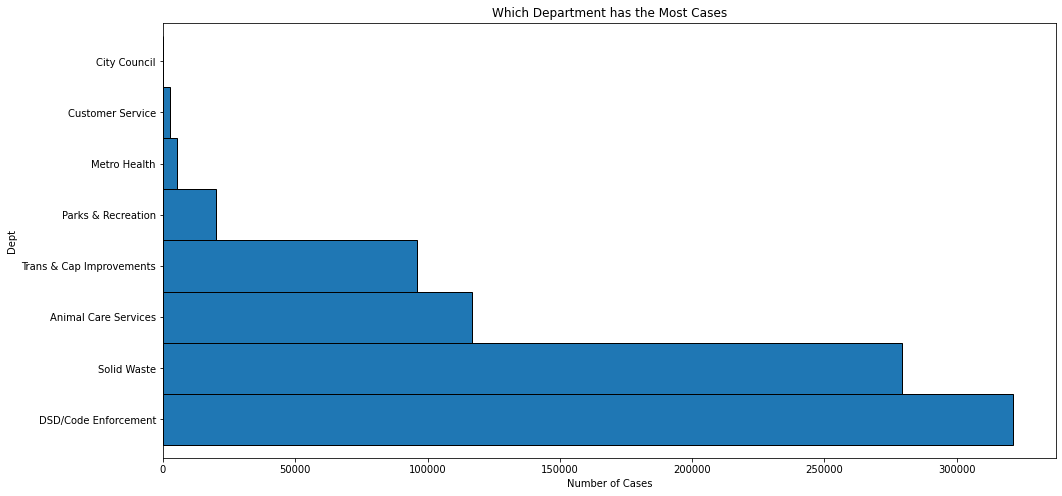

In [15]:
(
    df.groupBy("department")
    .count()
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(16,8))
)    

plt.title("Which Department has the Most Cases")
plt.ylabel("Dept")
plt.xlabel("Number of Cases")
plt.show()

- Does the percentage of cases that are late vary by department?

In [17]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [18]:
(
    df.where("case_late")
    .groupBy("department")
    .count("*")
    .show(1, truncate=False)
)

TypeError: _api() takes 1 positional argument but 2 were given

- On average, how late are the late cases by department?

In [ ]:
df.show(1, vertical=True)

- What is the service type that is the most late? Just for Parks & Rec?

In [ ]:
df.show(1, vertical=True)

- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [ ]:
df.show(1, vertical=True)

- Does whether or not its a weekend matter for when a case is opened/closed?

In [ ]:
df.show(1, vertical=True)

- On average, how many cases are opened a day for the Customer Service department?

In [ ]:
df.show(1, vertical=True)

- Does the number of service requests for the solid waste department vary by day of the week?

In [ ]:
df.show(1, vertical=True)